Notebook on time series causality, part 2

TO DO
- Using *resids* which are residuals, although we want structural shock series in replication regressions. Structural shock series not available in statsmodels output? 

## Imports

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as sm_form
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.moment_helpers import corr2cov
np.random.seed(5000)

import rpy2
%load_ext rpy2.ipython

In [2]:
%%R 
library(dagitty)

In [3]:
#!curl -O "https://raw.githubusercontent.com/vitorcurtis/RWinOut/master/RWinOut.py

In [4]:
%load_ext RWinOut

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## DGP

$
\begin{align*}
Y_{1,t} & = b_{1,1} Y_{1,t-1} + b_{1,3} Y_{3,t-1} + u_{1,t} \\
Y_{2,t} & = b_{2,1} Y_{1,t-1} + b_{2,2} Y_{2,t-1} + b_{2,3} Y_{3,t-1} + u_{2,t} \\
Y_{3,t} & = b_{3,3} Y_{3,t-1} + u_{3,t} \\
\end{align*}
$

where $t \geq 1$ and $
\begin{align*}
Y_0 = \begin{bmatrix} Y_{1,0} \\ Y_{2,0} \\ Y_{3,0} \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}
\end{align*}
$

and with $b_{1,1} = 0.8$, $b_{1,3} = -0.55$, $b_{2,1} = -0.5$, $b_{2,2} = 0.7$, $b_{2,3} = 0.65$ and $b_{3,3} = -0.6$. 

Shocks correlation matrix:

$
\begin{align*}
\mathbf{\Sigma}_u = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}
\end{align*}
$

In this DGP $Y_{1,t}$ and $Y_{2,t}$ are correlated through $Y_{1,t-1}$.

We are interested in effects $\omega_{1,t} \rightarrow y_{2,t+1}$ and $\omega_{1,t} \rightarrow y_{2,t+2}$. According to DGP the true affects are
 - $\omega_{1,t} \rightarrow y_{2,t+1}$: 1 (0.5) = -0.5
 - $\omega_{1,t} \rightarrow y_{2,t+2}$: 1 (0.8) (-0.5) + 1 (-0.5)  0.7 = -0.4 - 0.35 = -0.75

Directed acyclic graph of the DGP:

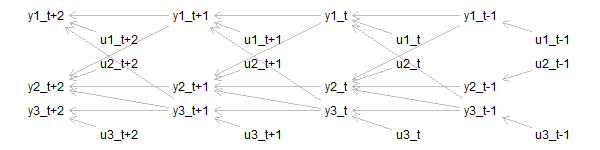

[1] "Adjustment set for u1_t direct effect on y2_t+1:"
{ y1_t, y2_t, y3_t }
{ y1_t, y2_t, y3_t-1 }
{ y1_t, y1_t-1, y3_t-1 }
[1] "--------------------"
[1] "Adjustment set for u1_t total effect on y2_t+1:"
 {}
[1] "---------------------------------------------------------------------"
[1] "Adjustment set for u1_t direct effect on y2_t+2:"
{ y1_t+1, y2_t+1, y3_t+1 }
{ y1_t+1, y2_t+1, y3_t }
{ y1_t, y2_t+1, y3_t }
{ y1_t, y2_t, y3_t }
{ y1_t, y2_t, y3_t-1 }
{ y1_t, y1_t-1, y3_t-1 }
[1] "--------------------"
[1] "Adjustment set for u1_t total effect on y2_t+2:"
 {}


In [5]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t+2" [pos="0,1"]
    "y2_t+2" [pos="0,4"]
    "u1_t+2" [pos="1,2"]
    "u2_t+2" [pos="1,3"]
    "y1_t+1" [pos="2,1"]
    "y2_t+1" [pos="2,4"]
    "u1_t+1" [pos="3,2"]
    "u2_t+1" [pos="3,3"]
    "y1_t"   [pos="4,1"]
    "y2_t"   [pos="4,4"]
    "u1_t"   [pos="5,2"]
    "u2_t"   [pos="5,3"]
    "y1_t-1" [pos="6,1"]
    "y2_t-1" [pos="6,4"]
    "u1_t-1" [pos="7,2"]
    "u2_t-1" [pos="7,3"]
    "y3_t+2" [pos="0,5"]
    "u3_t+2" [pos="1,6"]
    "y3_t+1" [pos="2,5"]
    "u3_t+1" [pos="3,6"]      
    "y3_t"   [pos="4,5"]
    "u3_t"   [pos="5,6"]      
    "y3_t-1" [pos="6,5"]
    "u3_t-1" [pos="7,6"]      
    "y1_t+2" <- "y1_t+1" <- "y1_t" <- "y1_t-1"
    "y2_t+2" <- "y2_t+1" <- "y2_t" <- "y2_t-1"
    "y1_t+2" <- "u1_t+2"
    "y1_t+1" <- "u1_t+1"
    "y1_t"   <- "u1_t"
    "y1_t-1" <- "u1_t-1"
    "y2_t+2" <- "u2_t+2"
    "y2_t+1" <- "u2_t+1"
    "y2_t"   <- "u2_t"
    "y2_t-1" <- "u2_t-1"
    "y2_t+2" <- "y1_t+1"
    "y2_t+1" <- "y1_t"
    "y2_t"   <- "y1_t-1"
    "y1_t+2" <- "y3_t+1" -> "y2_t+2"
    "y1_t+1" <- "y3_t" -> "y2_t+1"
    "y1_t"   <- "y3_t-1" -> "y2_t"
    "y3_t+2" <- "y3_t+1"
    "y3_t+1" <- "y3_t"
    "y3_t"   <- "y3_t-1"
    "y3_t+2" <- "u3_t+2"
    "y3_t+1" <- "u3_t+1"
    "y3_t"   <- "u3_t"
    "y3_t-1" <- "u3_t-1"
}')
plot(g)

print("Adjustment set for u1_t direct effect on y2_t+1:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+1", effect="direct"))
print("--------------------")
print("Adjustment set for u1_t total effect on y2_t+1:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+1", effect="total"))
print("---------------------------------------------------------------------")
print("Adjustment set for u1_t direct effect on y2_t+2:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+2", effect="direct"))
print("--------------------")
print("Adjustment set for u1_t total effect on y2_t+2:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+2", effect="total"))

### Simualate data according to DGP

L1.y1.y1 :0.8
L1.y2.y1 :0.0
L1.y3.y1 :-0.55
L1.y1.y2 :-0.5
L1.y2.y2 :0.7
L1.y3.y2 :0.65
L1.y1.y3 :0.0
L1.y2.y3 :0.0
L1.y3.y3 :-0.6
sqrt.var.y1 :1.0
sqrt.cov.y1.y2 :0.0
sqrt.var.y2 :1.0
sqrt.cov.y1.y3 :0.0
sqrt.cov.y2.y3 :0.0
sqrt.var.y3 :1.0


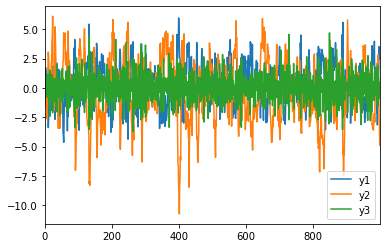

In [6]:
initial_state = [0, 0, 0]
coefs = np.array([
       [0.8, 0, -0.55], 
       [-0.5, 0.7, 0.65],
       [0, 0, -0.6],       
]).flatten(order="C")
corr = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
])
stds = [1, 1, 1]
cov = np.sqrt(corr2cov(corr, stds))

endog = pd.DataFrame({"y1":[np.nan, np.nan], "y2":[np.nan, np.nan], "y3":[np.nan, np.nan]}, index=[0, 1])
mod = sm.tsa.VARMAX(endog, order=(1, 0), trend="n")
params = np.concatenate([coefs, np.sqrt(cov[np.tril_indices(cov.shape[0])])], axis=0)
print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))
df = pd.DataFrame(mod.simulate(params=params, nsimulations=1000, initial_state=initial_state))
_ = df.plot()

## Model 1: "Perfect model"

In first model we "guess" the structure correctly and fit a 3-variable reduced-form VAR(1) process to simualted data:

$
\begin{align*}
Y_{1,t} & = \beta_{1,1} Y_{1,t-1} + \beta_{1,2} Y_{1,t-1}+ \beta_{1,3} Y_{3,t-1} + \epsilon_{1,t} \\
Y_{2,t} & = \beta_{2,1} Y_{1,t-1} + \beta_{2,2} Y_{2,t-1}+ \beta_{2,3} Y_{3,t-1} + \epsilon_{2,t} \\
Y_{3,t} & = \beta_{3,1} Y_{1,t-1} + \beta_{3,2} Y_{2,t-1}+ \beta_{3,3} Y_{3,t-1} + \epsilon_{3,t} \\
\end{align*}
$

For structural identification/impulse responses we use Cholesky decomposition such that

$
\begin{align*}
\begin{bmatrix} \epsilon_{1,t}  \\ \epsilon_{2,t} \\ \epsilon_{3,t} \end{bmatrix} = \begin{bmatrix} ? & 0 & 0 \\ ? & ? & 0 \\ ? & ? & ? \end{bmatrix} \begin{bmatrix} \omega_{1,t} \\ \omega_{2,t} \\ \omega_{3,t} \end{bmatrix}
\end{align*}
$

Estimate VAR and similar SVAR:

In [7]:
model1_var = sm.tsa.VAR(df)
res1_var = model1_var.fit(maxlags=1)
irf1_var = res1_var.irf(5)

# SVAR
D = np.asarray([
    ["E", 0, 0],
    ["E", "E", 0],
    ["E", "E", "E"],    
])
model1_svar = sm.tsa.SVAR(df.copy(), svar_type='A', A=D)
res1_svar = model1_svar.fit(maxlags=1)
irf1_svar = res1_svar.irf(5)

### Estimation results - cofficients and residuals

Coefficients correctly retrieved. Since the regressions model guesses DGP accurately, residuals reflect true uncorrelated DGP shocks.

In [8]:
res1_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Sep, 2020
Time:                     08:21:13
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                 -0.0351060
Nobs:                     999.000    HQIC:                -0.0716436
Log likelihood:          -4193.58    FPE:                   0.910241
AIC:                   -0.0940460    Det(Omega_mle):        0.899394
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.067169         0.031322            2.144           0.032
L1.y1         0.777008         0.024014           32.357           0.000
L1.y2        -0.001936         0.015270           -0.127           0.899
L1.y3        -0.573052

### Reduced-form residuals and structural shocks from SVAR

In [9]:
display(pd.DataFrame(np.corrcoef(res1_svar.resid, rowvar=False)))
# Put structural shocks into data frame; make sure time index matches as series is of length len(df)-1
resid1_structural = pd.DataFrame(np.matmul(res1_svar.A, res1_svar.resid.T).T, columns=df.columns, index=list(range(1, len(res1_svar.resid)+1)))
display(pd.DataFrame(np.corrcoef(resid1_structural, rowvar=False)))

,0,1,2
0,1.000000,-0.046053,0.009947
1,-0.046053,1.000000,0.041147
2,0.009947,0.041147,1.000000


,0,1,2
0,1.000000e+00,-6.737234e-08,-6.963492e-08
1,-6.737234e-08,1.000000e+00,-1.602865e-08
2,-6.963492e-08,-1.602865e-08,1.000000e+00


### Structural impulse responses and structural impact multiplier matrix

We give two plots: strctural impulse responses from SVAR, and orthognalized impulse responeses from VAR. As our SVAR identifcation scheme is Wold causal ordering, results should coincide. For the most part they do, but in SVAR case the off-diagonal elements confidence boands are weirdly concentrated at impact period, whereas in VAR case they are not, making more sense. Why this is the case is still unknown to me.

Our identification scheme allows for contemporaneous cross-effects $\omega_{1,t} \rightarrow y_{2,t}$, $\omega_{1,t} \rightarrow y_{3,t}$ and $\omega_{2,t} \rightarrow y_{3,t}$ although in the DGP there are no such effects.

There is some action in off-diagonal, instantaneous effects, but pretty close to zero as they should be. All in all we get pretty accurate estimates for impacts $\omega_{1,t} \rightarrow y_{2,t+1}$ and $\omega_{1,t} \rightarrow y_{2,t+2}$.

In [10]:
display(pd.DataFrame(np.linalg.inv(res1_svar.A)))

,0,1,2
0,0.978817,0.000000,0.000000
1,-0.044747,0.970628,0.000000
2,0.009939,0.041612,0.998207


Estimated effect of w1_t on y2_t+1 is about -0.54, while true value is -0.5
Estimated effect of w1_t on y2_t+2 is about -0.75, while true value is -0.75


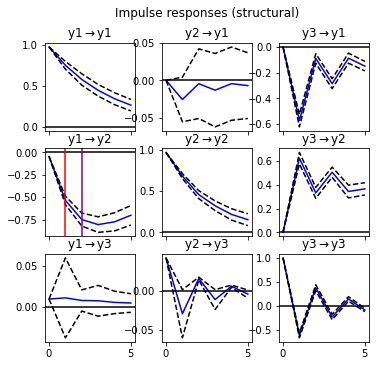

In [11]:
fig = irf1_svar.plot()
fig.suptitle(fig._suptitle.get_text(), fontsize=12)
fig.set_size_inches(5, 5)
plt.subplots_adjust(top=0.88, wspace=0.3)
ax = fig.get_axes()[3]
ax.axvline(x=1, c="r")
ax.axvline(x=2, c="purple")
print("Estimated effect of w1_t on y2_t+1 is about {:.2f}, while true value is {}".format(irf1_svar.svar_irfs[1, 1, 0], -0.5))
print("Estimated effect of w1_t on y2_t+2 is about {:.2f}, while true value is {}".format(irf1_svar.svar_irfs[2, 1, 0], -0.75))

For comparison, orthoganalized impulse responses from VAR:

Estimated effect of w1_t on y2_t+1 is about -0.54, while true value is -0.5
Estimated effect of w1_t on y2_t+2 is about -0.75, while true value is -0.75


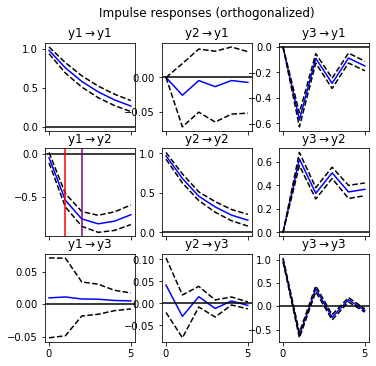

In [12]:
fig = irf1_var.plot(orth=True)
fig.suptitle(fig._suptitle.get_text(), fontsize=12)
fig.set_size_inches(5, 5)
plt.subplots_adjust(top=0.88, wspace=0.3)
ax = fig.get_axes()[3]
ax.axvline(x=1, c="r")
ax.axvline(x=2, c="purple")
print("Estimated effect of w1_t on y2_t+1 is about {:.2f}, while true value is {}".format(irf1_var.orth_irfs[1, 1, 0], -0.5))
print("Estimated effect of w1_t on y2_t+2 is about {:.2f}, while true value is {}".format(irf1_var.orth_irfs[2, 1, 0], -0.75))

### Replicate result of $\omega_{1,t}$ total effect on $y_{2, t+1}$ from impulse responses with a simple linear regression

Somewhat more off compared to impulse responses, but otherwise checks out!

In [13]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg["y3_l1"] = df["y3"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(1)
gg["y2_l1"] = gg["y2_l1"].shift(1)
gg["y3_l1"] = gg["y3_l1"].shift(1)
gg["w1_l1"] = resid1_structural["y1"].copy().shift(1)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y2 ~ w1_l1 -1", data=gg.dropna()).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.045
Model:                            OLS   Adj. R-squared (uncentered):              0.044
Method:                 Least Squares   F-statistic:                              47.10
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                    1.18e-11
Time:                        08:21:16   Log-Likelihood:                         -2352.0
No. Observations:                 998   AIC:                                      4706.
Df Residuals:                     997   BIC:                                      4711.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$, $y_{2, t}$ and $y_{3, t}$? We would get *direct* effect of $\omega_{1, t}$, which is estimated around zero as expected. Estimates for lagged endogenous variables are fairly accurate.

In [14]:
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + y3_l1 + w1_l1 -1", data=gg.dropna()).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.862
Model:                            OLS   Adj. R-squared (uncentered):              0.862
Method:                 Least Squares   F-statistic:                              1555.
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                        0.00
Time:                        08:21:16   Log-Likelihood:                         -1385.9
No. Observations:                 998   AIC:                                      2780.
Df Residuals:                     994   BIC:                                      2799.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

### Replicate result of $\omega_{1,t}$ total effect on $y_{2, t+2}$ from impulse responses with a simple linear regression

Checks out!

In [15]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg["y3_l1"] = df["y3"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(2)
gg["y2_l1"] = gg["y2_l1"].shift(2)
gg["y3_l1"] = gg["y3_l1"].shift(2)
gg["w1_l2"] = resid1_structural["y1"].copy().shift(2)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y2 ~ w1_l2 -1", data=gg.dropna()).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.081
Model:                            OLS   Adj. R-squared (uncentered):              0.080
Method:                 Least Squares   F-statistic:                              87.79
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                    4.73e-20
Time:                        08:21:16   Log-Likelihood:                         -2331.0
No. Observations:                 997   AIC:                                      4664.
Df Residuals:                     996   BIC:                                      4669.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$, $y_{2, t}$ and $y_{3, t}$? We would get *direct* effect of $\omega_{1, t}$, which is estimated around zero as expected.

In [16]:
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + y3_l1 + w1_l2 -1", data=gg.dropna()).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.684
Model:                            OLS   Adj. R-squared (uncentered):              0.683
Method:                 Least Squares   F-statistic:                              538.3
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                   7.31e-247
Time:                        08:21:16   Log-Likelihood:                         -1798.2
No. Observations:                 997   AIC:                                      3604.
Df Residuals:                     993   BIC:                                      3624.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

## Model 2: Model with 2 variables

In second model we treat variable $Y_{3}$ as unobserved. We fit a 2-variable reduced-form VAR(1) process to simualted data:

$
\begin{align*}
Y_{1,t} & = \beta_{1,1} Y_{1,t-1} + \beta_{1,2} Y_{1,t-1}+ \beta_{1,3} Y_{3,t-1} + \epsilon_{1,t} \\
Y_{2,t} & = \beta_{2,1} Y_{1,t-1} + \beta_{2,2} Y_{2,t-1}+ \beta_{2,3} Y_{3,t-1} + \epsilon_{2,t} \\
\end{align*}
$

For structural identification/impulse responses we use Cholesky decomposition such that

$
\begin{align*}
\begin{bmatrix} \epsilon_{1,t}  \\ \epsilon_{2,t} \end{bmatrix} = \begin{bmatrix} ? & 0 \\ ? & ? \end{bmatrix} \begin{bmatrix} \omega_{1,t} \\ \omega_{2,t} \end{bmatrix}
\end{align*}
$

Estimate VAR and similar SVAR:

In [17]:
# VAR
model2_var = sm.tsa.VAR(df[["y1", "y2"]])
res2_var = model2_var.fit(maxlags=1)
irf2_var = res2_var.irf(5)

# SVAR
D = np.asarray([
    ["E", 0],
    ["E", "E"],
])
model2_svar = sm.tsa.SVAR(df[["y1", "y2"]].copy(), svar_type='A', A=D)
res2_svar = model2_svar.fit(maxlags=1)
irf2_svar = res2_svar.irf(5)

### Estimation results - cofficients and residuals

Coefficients pretty well estimated. But now there is correlation between residuals even though there is no contemporanoues correaltion in DGP: when influence of $Y_{3,t-1}$ in DGP is big/ckear enough on $Y_{1,t}$ and $Y_{2,t}$, excluding it from VAR induces correlation between $\epsilon_{1,t}$ and $\epsilon_{2,t}$.

In [18]:
res2_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Sep, 2020
Time:                     08:21:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.684750
Nobs:                     999.000    HQIC:                  0.666481
Log likelihood:          -3156.35    FPE:                    1.92568
AIC:                     0.655280    Det(Omega_mle):         1.91417
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.079910         0.038743            2.063           0.039
L1.y1         0.685734         0.029299           23.404           0.000
L1.y2        -0.007428         0.018889           -0.393           0.694

Results for equation 

### Reduced-form residuals and structural shocks from SVAR

In [19]:
display(pd.DataFrame(np.corrcoef(res2_svar.resid, rowvar=False)))
# Put structural shocks into data frame; make sure time index matches as series is of length len(df)-1
resid2_structural = pd.DataFrame(np.matmul(res2_svar.A, res2_svar.resid.T).T, columns=df.columns[:2], index=list(range(1, len(res2_svar.resid)+1)))
display(pd.DataFrame(np.corrcoef(resid2_structural, rowvar=False)))

,0,1
0,1.000000,-0.397918
1,-0.397918,1.000000


,0,1
0,1.000000e+00,-2.403626e-07
1,-2.403626e-07,1.000000e+00


### Structural impulse responses and structural impact multiplier matrix

Our identification scheme allows for contemporaneous cross-effects $\omega_{1,t} \rightarrow y_{2,t}$. In reality there is no such effect as $u_{1,t}$ does not affect $y_{2,t}$. This time however we do pick contemporaneous effect due to misspecification of the model.

As with model 1, we give two plots: strctural impulse responses from SVAR, and orthognalized impulse responeses from VAR

In [20]:
display(pd.DataFrame(np.linalg.inv(res2_svar.A)))

,0,1
0,1.210900,0.000000
1,-0.495571,1.142565


Estimated effect of w1_t on y2_t+1 is about -0.85, while true value is -0.5
Estimated effect of w1_t on y2_t+2 is about -0.93, while true value is -0.75


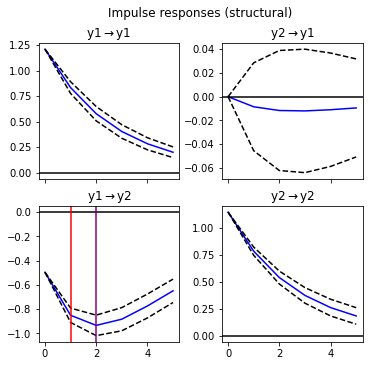

In [21]:
fig = irf2_svar.plot()
fig.suptitle(fig._suptitle.get_text(), fontsize=12)
fig.set_size_inches(5, 5)
plt.subplots_adjust(top=0.88, wspace=0.3)
_, _, ax, _ = fig.get_axes()
ax.axvline(x=1, c="r")
ax.axvline(x=2, c="purple")
print("Estimated effect of w1_t on y2_t+1 is about {:.2f}, while true value is {}".format(irf2_svar.svar_irfs[1, 1, 0], -0.5))
print("Estimated effect of w1_t on y2_t+2 is about {:.2f}, while true value is {}".format(irf2_svar.svar_irfs[2, 1, 0], -0.75))

Estimated effect of w1_t on y2_t+1 is about -0.85, while true value is -0.5
Estimated effect of w1_t on y2_t+2 is about -0.93, while true value is -0.75


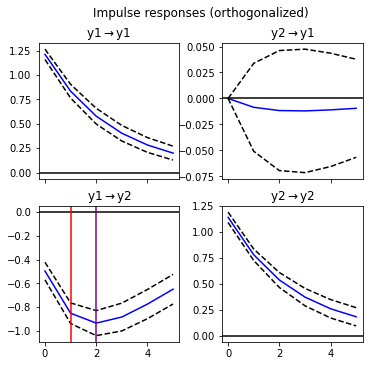

In [22]:
fig = irf2_var.plot(orth=True)
fig.suptitle(fig._suptitle.get_text(), fontsize=12)
fig.set_size_inches(5, 5)
plt.subplots_adjust(top=0.88, wspace=0.3)
_, _, ax, _ = fig.get_axes()
ax.axvline(x=1, c="r")
ax.axvline(x=2, c="purple")
print("Estimated effect of w1_t on y2_t+1 is about {:.2f}, while true value is {}".format(irf2_var.orth_irfs[1, 1, 0], -0.5))
print("Estimated effect of w1_t on y2_t+2 is about {:.2f}, while true value is {}".format(irf2_var.orth_irfs[2, 1, 0], -0.75))

### Replicate result of $\omega_{1,t}$ total effect on $y_{2, t+1}$ from impulse responses with a simple linear regression

Point-estimate seems more accurate than the impulse-response of mis-specified VAR. Not sure why this is. 

In [23]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(1)
gg["y2_l1"] = gg["y2_l1"].shift(1)
gg["w1_l1"] = resid2_structural["y1"].copy().shift(1)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y2 ~ w1_l1 -1", data=gg.dropna()).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.070
Model:                            OLS   Adj. R-squared (uncentered):              0.069
Method:                 Least Squares   F-statistic:                              75.21
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                    1.70e-17
Time:                        08:21:18   Log-Likelihood:                         -2338.7
No. Observations:                 998   AIC:                                      4679.
Df Residuals:                     997   BIC:                                      4684.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$ and $y_{2, t}$? We get wildly biased effect for $\omega_1$!

In [24]:
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + w1_l1 -1", data=gg.dropna()).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.783
Model:                            OLS   Adj. R-squared (uncentered):              0.782
Method:                 Least Squares   F-statistic:                              1193.
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                        0.00
Time:                        08:21:18   Log-Likelihood:                         -1613.7
No. Observations:                 998   AIC:                                      3233.
Df Residuals:                     995   BIC:                                      3248.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

### Replicate result of $\omega_{1,t}$ total effect on $y_{2, t+2}$ from impulse responses with a simple linear regression

Pretty much the same as in impulse response case.

In [25]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(1)
gg["y2_l1"] = gg["y2_l1"].shift(1)
gg["w1_l2"] = resid2_structural["y1"].copy().shift(2)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y2 ~ w1_l2 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.130
Model:                            OLS   Adj. R-squared (uncentered):              0.129
Method:                 Least Squares   F-statistic:                              148.5
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                    6.18e-32
Time:                        08:21:18   Log-Likelihood:                         -2303.8
No. Observations:                 997   AIC:                                      4610.
Df Residuals:                     996   BIC:                                      4615.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$ and $y_{2, t}$? Again wildly biased effect for $\omega_1$, althoug not at least sign is correct.

In [26]:
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + w1_l2 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.780
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                              1176.
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                        0.00
Time:                        08:21:18   Log-Likelihood:                         -1617.7
No. Observations:                 997   AIC:                                      3241.
Df Residuals:                     994   BIC:                                      3256.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

## Appendix

Illustration of DGP without observing $Y_{3}$ looks as follows (bidirected edges are shorthands for substructures <-U->, where U is an unobserved variable):

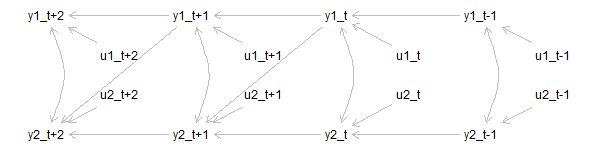

In [27]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t+2" [pos="0,1"]
    "y2_t+2" [pos="0,4"]
    "u1_t+2" [pos="1,2"]
    "u2_t+2" [pos="1,3"]
    "y1_t+1" [pos="2,1"]
    "y2_t+1" [pos="2,4"]
    "u1_t+1" [pos="3,2"]
    "u2_t+1" [pos="3,3"]
    "y1_t"   [pos="4,1"]
    "y2_t"   [pos="4,4"]
    "u1_t"   [pos="5,2"]
    "u2_t"   [pos="5,3"]
    "y1_t-1" [pos="6,1"]
    "y2_t-1" [pos="6,4"]
    "u1_t-1" [pos="7,2"]
    "u2_t-1" [pos="7,3"]    
    "y1_t+2" <- "y1_t+1" <- "y1_t" <- "y1_t-1"
    "y2_t+2" <- "y2_t+1" <- "y2_t" <- "y2_t-1"
    "y1_t+2" <- "u1_t+2"
    "y1_t+1" <- "u1_t+1"
    "y1_t"   <- "u1_t"
    "y1_t-1" <- "u1_t-1"
    "y2_t+2" <- "u2_t+2"
    "y2_t+1" <- "u2_t+1"
    "y2_t"   <- "u2_t"
    "y2_t-1" <- "u2_t-1"
    "y2_t+2" <- "y1_t+1"
    "y2_t+1" <- "y1_t"
    "y1_t+2" <-> "y2_t+2"
    "y1_t+1" <-> "y2_t+1"
    "y1_t"   <-> "y2_t"
    "y1_t-1" <-> "y2_t-1"
}')
plot(g)

And we are estimating a model that assumes this:

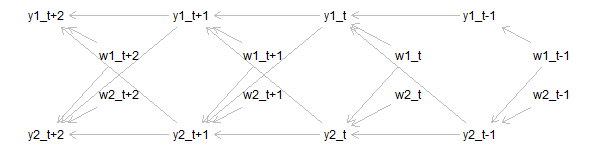

In [28]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t+2" [pos="0,1"]
    "y2_t+2" [pos="0,4"]
    "w1_t+2" [pos="1,2"]
    "w2_t+2" [pos="1,3"]
    "y1_t+1" [pos="2,1"]
    "y2_t+1" [pos="2,4"]
    "w1_t+1" [pos="3,2"]
    "w2_t+1" [pos="3,3"]
    "y1_t"   [pos="4,1"]
    "y2_t"   [pos="4,4"]
    "w1_t"   [pos="5,2"]
    "w2_t"   [pos="5,3"]
    "y1_t-1" [pos="6,1"]
    "y2_t-1" [pos="6,4"]
    "w1_t-1" [pos="7,2"]
    "w2_t-1" [pos="7,3"]    
    "y1_t+2" <- "y1_t+1" <- "y1_t" <- "y1_t-1"
    "y2_t+2" <- "y2_t+1" <- "y2_t" <- "y2_t-1"
    "y1_t+2" <- "w1_t+2"
    "y1_t+1" <- "w1_t+1"
    "y1_t"   <- "w1_t"
    "y1_t-1" <- "w1_t-1"
    "w1_t+2" -> "y2_t+2" <- "w2_t+2"
    "w1_t+1" -> "y2_t+1" <- "w2_t+1"
    "w1_t" -> "y2_t"   <- "w2_t"
    "w1_t-1" -> "y2_t-1" <- "w2_t-1"
    "y2_t+2" <- "y1_t+1"
    "y2_t+1" <- "y1_t"
    "y1_t+2" <- "y2_t+1"
    "y1_t+1" <- "y2_t"
    "y1_t"   <- "y2_t-1"
}')
plot(g)

If we are willing to assume that the unobservable correlation is due to a fork (as it actually is), our modelling situation looks like below ($U_t$ is unobserved variable):
 - Not quite sure if this is 100% correct...

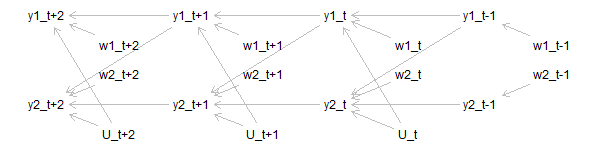

[1] "Adjustment set for u1_t direct effect on y2_t+1:"
{ y1_t, y2_t }
[1] "--------------------"
[1] "Adjustment set for u1_t total effect on y2_t+1:"
 {}
[1] "---------------------------------------------------------------------"
[1] "Adjustment set for u1_t direct effect on y2_t+2:"
{ y1_t+1, y2_t+1 }
{ y1_t, y2_t }
[1] "--------------------"
[1] "Adjustment set for u1_t total effect on y2_t+2:"
 {}


In [29]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t+2" [pos="0,1"]
    "y2_t+2" [pos="0,4"]
    "w1_t+2" [pos="1,2"]
    "w2_t+2" [pos="1,3"]
    "y1_t+1" [pos="2,1"]
    "y2_t+1" [pos="2,4"]
    "w1_t+1" [pos="3,2"]
    "w2_t+1" [pos="3,3"]
    "y1_t"   [pos="4,1"]
    "y2_t"   [pos="4,4"]
    "w1_t"   [pos="5,2"]
    "w2_t"   [pos="5,3"]
    "y1_t-1" [pos="6,1"]
    "y2_t-1" [pos="6,4"]
    "w1_t-1" [pos="7,2"]
    "w2_t-1" [pos="7,3"]
    "U_t+2"  [latent pos="1,5"]      
    "U_t+1"  [latent pos="3,5"]      
    "U_t"    [latent pos="5,5"]
    "y1_t+2" <- "y1_t+1" <- "y1_t" <- "y1_t-1"
    "y2_t+2" <- "y2_t+1" <- "y2_t" <- "y2_t-1"
    "y1_t+2" <- "w1_t+2"
    "y1_t+1" <- "w1_t+1"
    "y1_t"   <- "w1_t"
    "y1_t-1" <- "w1_t-1"
    "y2_t+2" <- "w2_t+2"
    "y2_t+1" <- "w2_t+1"
    "y2_t"   <- "w2_t"
    "y2_t-1" <- "w2_t-1"
    "y2_t+2" <- "y1_t+1"
    "y2_t+1" <- "y1_t"
    "y2_t"   <- "y1_t-1"
    "y1_t+2" <- "U_t+2" -> "y2_t+2"
    "y1_t+1" <- "U_t+1" -> "y2_t+1"
    "y1_t"   <- "U_t" -> "y2_t"
}')
plot(g)

print("Adjustment set for u1_t direct effect on y2_t+1:")
print(adjustmentSets(g, exposure="w1_t", outcome="y2_t+1", effect="direct"))
print("--------------------")
print("Adjustment set for u1_t total effect on y2_t+1:")
print(adjustmentSets(g, exposure="w1_t", outcome="y2_t+1", effect="total"))
print("---------------------------------------------------------------------")
print("Adjustment set for u1_t direct effect on y2_t+2:")
print(adjustmentSets(g, exposure="w1_t", outcome="y2_t+2", effect="direct"))
print("--------------------")
print("Adjustment set for u1_t total effect on y2_t+2:")
print(adjustmentSets(g, exposure="w1_t", outcome="y2_t+2", effect="total"))